# Entire workflow for 32 column run 

In this notebook, I will try to document every step currently required from the raw SP training data to a neural network online run with analysis. The hope is 1) to provide an introduction for people new to this code and (more importantly) 2) show which bottlenecks there currently are in the workflow and where things could/should be improved.

Unfortunately, the code and the repository are quite messy at times. Sorry about that.

We will use the 32 column SPCAM training run, which has previously crashed, which gives us a good opportunity to do some analysis for a crashed run.

I will start working on my local machine in Munich, where I copied the raw data to. There I will do data preprocessing and network training. Then we will switch to Stampede2 to compile CAM, run the neural network version and analyze the output data.

In [2]:
# Imports
import xarray as xr

In [58]:
!pwd

/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/log


In [68]:
%cd ../../

'/home/s/S.Rasp/repositories/CBRAIN-CAM'

## Summary

Here are the commands necessary for the entire workflow.

### Part 1 - LMU

**Preprocessing**

Create config file (e.g. `32col_engy_ess_ref.yml`):
```
inputs : [TBP, QBP, VBP, PS, SOLIN, SHFLX, LHFLX]
outputs : [TPHYSTND, PHQ, FSNT, FSNS, FLNT, FLNS, PRECT]
in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/
out_dir: /local/S.Rasp/preprocessed_data/
```

Run preprocessing scripts:
```
python cbrain/preprocess_aqua.py \
--config pp_config/32col_engy_ess_ref.yml \
--aqua_names '*.h1.0000-*-0[1-3]-*' \
--out_pref 32_col_engy_ess_3d_train

python cbrain/preprocess_aqua.py \
--config pp_config/32col_engy_ess_ref.yml \
--aqua_names '*.h1.0000-*-1[1-3]-*' \
--out_pref 32_col_engy_ess_3d_valid --ext_norm Nope

python cbrain/shuffle_ds.py --pref /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train
```

**Neural network training**

Create config file (e.g. `001_32cols_engy_ess_3d_pnas.yml`):
```
exp_name: 001_32cols_engy_ess_3d_pnas
data_dir: /local/S.Rasp/preprocessed_data/
train_fn: 32_col_engy_ess_3d_train_shuffle
valid_fn: 32_col_engy_ess_3d_valid
norm_fn: 32_col_engy_ess_3d_train_norm.nc
fsub: feature_means
fdiv: max_rs
tmult: target_conv
activation: LeakyReLU
hidden_layers: [256,256,256,256,256,256,256,256,256]
loss: mse
log_dir: ./logs/
epochs: 18
lr_step: 3
```

Run NN script
```
python run_experiment.py -c nn_config/32cols/001_32cols_engy_ess_3d_pnas.yml
```

Convert to text files
```
python save_weights.py -c nn_config/32cols/001_32cols_engy_ess_3d_pnas.yml
```

### Part 2 - Stampede

Copy text files from LMU to Stampede:
```
weights_from_lmu 001_32cols_engy_ess_3d_pnas
```

Change network architecture in `cloudbrain_keras_dense.F90`. Additionally, make other changes before compiling.

```
build
```

Copy to scratch and create a new run directory

```
cds
mkdir nncam_001_32cols_engy_ess_3d_pnas
cd nncam_001_32cols_engy_ess_3d_pnas/
```

Copy cam binary, network parameters, initial condition file and template namelist and batch files.
```
cp /home1/05488/tg847872/spcam3-nn-build/run/cam ./
cp -r /home1/05488/tg847872/saved_models/001_32cols_engy_ess_3d_pnas ./keras_matrices
cp /work/05488/tg847872/stampede2/ic_bc/spinup_AndKua_aqua_SPCAM3.0.cam2.i.0000-12-02-00000.nc ./
cp /from/somewhere/atm_in /from/somewhere/run.slurm ./
```

Edit `atm_in`(`caseid`, potentially output, run length) and `run.slurm` (batch ID, queue and **directory**.)

Start interactive session:
```
interactive
```

Run NNCAM:
```
bash run.slurm >> out.txt &
```



## Preprocessing: from raw data to neural network input

The goal of the preprocessing is to convert the raw SPCAM output data to a format which can easily and quickly be used during neural network training.

### The raw data

The raw data is saved in daily files, each approximately 900MB large (h1 files contain the necessary data). For this 32 column version, there is 1 year and 3 months of data. For storage information of raw files, check https://github.com/raspstephan/CBRAIN-CAM/wiki/Raw-SPCAM-runs-(to-be-used-for-network-training)

In [12]:
#RAW_DATA = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
RAW_DATA = '/local/S.Rasp/sp32fbp_andkua/'   #SSD drive

! executes a command line script from within the notebook!

In [14]:
!ls -hl $RAW_DATA*h1* | head -5

-rwxr-xr-x 1 S.Rasp ls-craig 881M Apr  7  2018 /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc
-rwxr-xr-x 1 S.Rasp ls-craig 881M Apr  7  2018 /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-02-00000.nc
-rwxr-xr-x 1 S.Rasp ls-craig 881M Apr  7  2018 /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-03-00000.nc
-rwxr-xr-x 1 S.Rasp ls-craig 881M Apr  7  2018 /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-04-00000.nc
-rwxr-xr-x 1 S.Rasp ls-craig 881M Apr  7  2018 /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-05-00000.nc
ls: write error: Broken pipe


In [10]:
ds = xr.open_dataset(RAW_DATA + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc', 
                     decode_times=False)   # This is necessary because of the way time is stored in SPCAM

In [11]:
ds

<xarray.Dataset>
Dimensions:       (crm_x: 32, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 ...
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 ...
D

### Preprocessing script

The preprocessing is currently handled by a script called `preprocess_aqua.py` in the `cbrain` directory of the repository. 

To train the neural network we look at the data column by column. If we want to e.g. use TAP and QAP for the input of the neural network, in the raw data these two variables would be saved at different locations of the disc, which makes reading slow. In order to quickly read the data during neural network training, this script concatenates the input and output vector and saves these vectors to disc. 

A second step done by the script is to compute variables, that are not directly available in the raw output. For example, `TBP` = `TAP - TPHYSTND * dt`. The exact meaning of the variables for SPCAM can be found here (...eventually): https://github.com/raspstephan/CBRAIN-CAM/wiki/What-exactly-happens-in-a-SPCAM-time-step%3F

The preprocessing script takes a number of arguments from the command line or from a configuration script. Let's write a configuration script.

In [15]:
!python cbrain/preprocess_aqua.py -h

usage: preprocess_aqua.py [-h] [--config_file CONFIG_FILE]
                          [--inputs INPUTS [INPUTS ...]]
                          [--outputs OUTPUTS [OUTPUTS ...]]
                          [--in_dir IN_DIR [IN_DIR ...]] [--out_dir OUT_DIR]
                          [--aqua_names AQUA_NAMES [AQUA_NAMES ...]]
                          [--out_pref OUT_PREF] [--chunk_size CHUNK_SIZE]
                          [--ext_norm EXT_NORM] [--min_lev MIN_LEV]
                          [--lat_range LAT_RANGE [LAT_RANGE ...]]
                          [--target_factor TARGET_FACTOR]
                          [--random_seed RANDOM_SEED] [--shuffle]
                          [--only_norm] [--flx_same_dt]
                          [--norm_features NORM_FEATURES]
                          [--norm_targets NORM_TARGETS] [--verbose]

Args that start with '--' (eg. --inputs) can also be set in a config file
(specified via --config_file). Config file syntax allows: key=value,
flag=true, stuff=[a,

In [16]:
!cat pp_config/32col_engy_ess_ref.yml

inputs : [TBP, QBP, VBP, PS, SOLIN, SHFLX, LHFLX]
outputs : [TPHYSTND, PHQ, FSNT, FSNS, FLNT, FLNS, PRECT]
in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/
out_dir: /local/S.Rasp/preprocessed_data/

In [21]:
PREPROC_DIR = '/local/S.Rasp/preprocessed_data/'

The most important arguments are:
- inputs: List of input variables, e.g. [TBP, QBP, VBP, PS, SOLIN, SHFLX, LHFLX]. `_BP` variables are computed as: `TAP - TPHYSTND*dt`
- outputs: List of output variables, e.g. [TPHYSTND, PHQ, FSNT, FSNS, FLNT, FLNS, PRECT]
- in_dir: Directory where SPCAM files are stored. I strongly recommend putting the files on a fast drive (e.g. /scratch/ on Greenplanet)
- aqua_names: Here you can put a string with placeholders `*`, e.g. `'*.h1.0001-*-*-*'` for all files from year 1 or `'*.h1.0000-*-1[7-9]-*'` for day 17-19 from each month of year 0.
- out_dir: directory where the processed files will be stored
- out_pref: Prefix for the output files. Give them some descriptive name, e.g. `my_experiment1`
- ext_norm: This is deprecated and ugly. If ext_norm = None (default), a normalization file will be computed from the data. This normalization file contains means, standard deviations, etc. For a full year of data this can take a long time. For this reason I chose to compute the normalization files for a sample of the data. The differences are small. If ext_norm is some string (just pick any jiberish) no normalization file will be computed but the data will still not be normalized. This is controlled by the `norm_features` and `norm_targets` options which are None and should stay so. The normalization happens later on the fly during network training.

Let's start by creating a training dataset using the first three days from each month of the first year of available data. This is a total of 36 days, so roughly a tenth of the entire year. I added timestamps to the script, so that we can see how much time each step in the preprocessing takes.

In [35]:
!python cbrain/preprocess_aqua.py \
--config pp_config/32col_engy_ess_ref.yml \
--aqua_names '*.h1.0000-*-0[1-3]-*' \
--out_pref 32_col_engy_ess_3d_train

Time checkpoint reading data: 13.15 s
Number of time steps: 1728
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Time checkpoint create datasets: 13.28 s
Time checkpoint reshape and rechunk: 13.75 s
Compute means and stds
Saving normalization file: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_norm.nc
Time checkpoint normalization arrays: 214.54 s
Time checkpoint rechunk and ds: 215.20 s
Save features: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_features.nc
Save targets: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_targets.nc
Total time: 292.96 s


Computing the normalization file actually takes longest. This involves computing statistics over the entire sample dimension. But it's not crucial to compute the exactly right statistics for normalization. E.g. when using the entire year as training data, the normalization file computed with a subset of the data is totally fine to use.

In [36]:
!ls $PREPROC_DIR/32_col*

/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_features.nc
/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_norm.nc
/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_targets.nc


Now we have a features and a target dataset plus a normalization dataset. Let's check all of them out.

In [37]:
xr.open_dataset('/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_features.nc')

<xarray.Dataset>
Dimensions:        (feature_lev: 94, sample: 14057472)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    time           (sample) int64 ...
    lat            (sample) float64 ...
    lon            (sample) float64 ...
    feature_names  (feature_lev) object ...
Dimensions without coordinates: sample
Data variables:
    features       (sample, feature_lev) float32 ...
Attributes:
    log:      \n    Time: 2019-01-08T12:45:18\n\n    Executed command:\n\n   ...

In [38]:
xr.open_dataset('/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_targets.nc')

<xarray.Dataset>
Dimensions:       (sample: 14057472, target_lev: 65)
Coordinates:
  * target_lev    (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    time          (sample) int64 ...
    lat           (sample) float64 ...
    lon           (sample) float64 ...
Dimensions without coordinates: sample
Data variables:
    targets       (sample, target_lev) float32 ...
    target_names  (target_lev) object ...
Attributes:
    log:      \n    Time: 2019-01-08T12:45:18\n\n    Executed command:\n\n   ...

We have two dimensions, `sample` and `target_lev`, which corresponds to the stacked vectors. Additionally we have the variable `target_names`, which is handy later.

In [41]:
xr.open_dataset('/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_targets.nc').target_names

<xarray.DataArray 'target_names' (target_lev: 65)>
array(['TPHYSTND_lev00', 'TPHYSTND_lev01', 'TPHYSTND_lev02', 'TPHYSTND_lev03',
       'TPHYSTND_lev04', 'TPHYSTND_lev05', 'TPHYSTND_lev06', 'TPHYSTND_lev07',
       'TPHYSTND_lev08', 'TPHYSTND_lev09', 'TPHYSTND_lev10', 'TPHYSTND_lev11',
       'TPHYSTND_lev12', 'TPHYSTND_lev13', 'TPHYSTND_lev14', 'TPHYSTND_lev15',
       'TPHYSTND_lev16', 'TPHYSTND_lev17', 'TPHYSTND_lev18', 'TPHYSTND_lev19',
       'TPHYSTND_lev20', 'TPHYSTND_lev21', 'TPHYSTND_lev22', 'TPHYSTND_lev23',
       'TPHYSTND_lev24', 'TPHYSTND_lev25', 'TPHYSTND_lev26', 'TPHYSTND_lev27',
       'TPHYSTND_lev28', 'TPHYSTND_lev29', 'PHQ_lev00', 'PHQ_lev01',
       'PHQ_lev02', 'PHQ_lev03', 'PHQ_lev04', 'PHQ_lev05', 'PHQ_lev06',
       'PHQ_lev07', 'PHQ_lev08', 'PHQ_lev09', 'PHQ_lev10', 'PHQ_lev11',
       'PHQ_lev12', 'PHQ_lev13', 'PHQ_lev14', 'PHQ_lev15', 'PHQ_lev16',
       'PHQ_lev17', 'PHQ_lev18', 'PHQ_lev19', 'PHQ_lev20', 'PHQ_lev21',
       'PHQ_lev22', 'PHQ_lev23', 'PHQ_l

In [40]:
xr.open_dataset('/local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_norm.nc')

<xarray.Dataset>
Dimensions:              (feature_lev: 94, target_lev: 65)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * target_lev           (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...
Attributes:
    log:      \n    Time: 2019-01-08T12:45:18\n\n    Executed command:\n\n   ...

The normalization file contains a number of statistics for the features and targets, which can then be used during training for normalization.

We would also like to have a separate validation dataset. For this we simply chose a different date range, the months available for the second year. For the validation dataset we do not need to compute a normalization file. 

In [71]:
!python cbrain/preprocess_aqua.py \
--config pp_config/32col_engy_ess_ref.yml \
--aqua_names '*.h1.0001-*-0[1-3]-*' \
--out_pref 32_col_engy_ess_3d_valid --ext_norm Nope

Time checkpoint reading data: 0.81 s
Number of time steps: 432
Cut time steps: [143 287]
Cut time steps: [143 287]
Time checkpoint create datasets: 0.90 s
Time checkpoint reshape and rechunk: 1.03 s
Load external normalization file
Time checkpoint normalization arrays: 1.03 s
Time checkpoint rechunk and ds: 1.13 s
Save features: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_valid_features.nc
Save targets: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_valid_targets.nc
Total time: 26.12 s


In [66]:
!ls -lh $PREPROC_DIR/32_col*

-rw-r--r-- 1 S.Rasp ls-craig 5.3G Jan  8 12:49 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_features.nc
-rw-r--r-- 1 S.Rasp ls-craig  24K Jan  8 12:48 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_norm.nc
-rw-r--r-- 1 S.Rasp ls-craig 5.3G Jan  8 13:03 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_shuffle_features.nc
-rw-r--r-- 1 S.Rasp ls-craig 3.8G Jan  8 13:03 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_shuffle_targets.nc
-rw-r--r-- 1 S.Rasp ls-craig 3.8G Jan  8 12:50 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_train_targets.nc
-rw-r--r-- 1 S.Rasp ls-craig 5.3G Jan  8 12:59 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_valid_features.nc
-rw-r--r-- 1 S.Rasp ls-craig 3.8G Jan  8 12:59 /local/S.Rasp/preprocessed_data//32_col_engy_ess_3d_valid_targets.nc


#### Speed comparison: regular hard-drive vs. SSD

I copy all the raw data to an SSD drive, in order to speed up the computation. We can load the data from a regular disc (but still save on SSD), to see the difference.

In [34]:
!python cbrain/preprocess_aqua.py \
--config pp_config/32col_engy_ess_ref.yml \
--in_dir /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/ --aqua_names '*.h1.0000-*-0[1-3]-*' \
--out_pref test_32_col_engy_ess_3d_train

Time checkpoint reading data: 40.51 s
Number of time steps: 1728
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Time checkpoint create datasets: 40.64 s
Time checkpoint reshape and rechunk: 42.67 s
Compute means and stds
Saving normalization file: /local/S.Rasp/preprocessed_data/test_32_col_engy_ess_3d_train_norm.nc
Time checkpoint normalization arrays: 1352.22 s
Time checkpoint rechunk and ds: 1352.89 s
Save features: /local/S.Rasp/preprocessed_data/test_32_col_engy_ess_3d_train_features.nc
Save targets: /local/S.Rasp/preprocessed_data/test_32_col_engy_ess_3d_train_targets.nc
Total time: 2062.98 s


Time to process 36 days:

SSD: 5 minutes    
Hard-drive: 36 minutes

#### TO DO: Entire year 

from root directory:
```
python cbrain/preprocess_aqua.py --config pp_config/32col_engy_ess_ref.yml --in_dir /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/ --aqua_names '*.h1.0000-*' --out_pref 32_col_engy_ess_1y_train --ext_norm Nope
```

### Shuffling the training dataset

During network training it's important that the samples in each batch are random. Currently they are still in order (lat-lon-time only have been flattened). Ideally, you would randomly shuffle during training. Because the datasets exceed RAM however, shuffling means reading random locations on disc for each sample in the batch. This is slow.

For this reason, I am pre-shuffling the training dataset once. Then during training, for each batch we will read a continuous slice of the shuffled dataset. Only the order of the batches is random. This should be a good enough approximation. 

Shuffling is done by the `shuffle_ds.py` script in the `cbrain` directory.

In [47]:
!python cbrain/shuffle_ds.py -h

usage: shuffle_ds.py [-h] [--method METHOD] [--pref PREF]
                     [--random_seed RANDOM_SEED] [--chunk_size CHUNK_SIZE]
                     [--verbose VERBOSE]

optional arguments:
  -h, --help            show this help message and exit
  --method METHOD       [Meticulous or fast]
  --pref PREF           Prefix. ie without the _features.nc
  --random_seed RANDOM_SEED
                        Random seed for shuffling of data.
  --chunk_size CHUNK_SIZE
                        Size of chunks for fast method
  --verbose VERBOSE     Verbosity level


In [48]:
!python cbrain/shuffle_ds.py --pref /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train

Reading files: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_features.nc /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_targets.nc
Creating files: /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_shuffle_features.nc /local/S.Rasp/preprocessed_data/32_col_engy_ess_3d_train_shuffle_targets.nc
100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.74s/it]


#### TO DO: Entire year

## Training the neural network and convert to 

Now we will use the preprocessed files and train the neural network. Then we will save the parameters of the network in text format to use them inside CAM.

For now I will only use the command line script `run_experiment.py` which is in the root directory of the repositories. At some point, I will go deeper and analyze what is actually going on during training. In particular, we need to look at the data_generator function, which reads and modifies the preprocessed data.

### Training a neural network

Again, the script takes a config file. The idea of the config files is to make the runs reproducible.

In [53]:
!cat nn_config/32cols/001_32cols_engy_ess_3d_pnas.yml

exp_name: 001_32cols_engy_ess_3d_pnas
data_dir: /local/S.Rasp/preprocessed_data/
train_fn: 32_col_engy_ess_3d_train_shuffle
valid_fn: 32_col_engy_ess_3d_valid
norm_fn: 32_col_engy_ess_3d_train_norm.nc
fsub: feature_means
fdiv: max_rs
tmult: target_conv
activation: LeakyReLU
hidden_layers: [256,256,256,256,256,256,256,256,256]
loss: mse
log_dir: ./logs/
epochs: 18
lr_step: 3


Some explanation:
- log_dir: This simply saves a Tensorboard log. I would not worry about this for now since it doesn't really give more information that the scores.
- lr_step: In addition to the simple example above, I aplemented a learning rate scheduler. I basically copied this: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ lr_step defines after how many epochs the learning rate is dropped.
- valid_after: If this is true, the validation score is only computed for the last epoch. This is reasonable once you know that your model behaves ok. Computing the validation score actually takes some time.
- model_dir and exp_name: The keras model is saved after training in the directory specified with the experiment name. We need the saved model to implement into CAM later.

In [51]:
!python run_experiment.py -h

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: run_experiment.py [-h] [-c CONFIG_FILE] [--exp_name EXP_NAME]
                         [--model_dir MODEL_DIR] [--data_dir DATA_DIR]
                         [--train_fn TRAIN_FN] [--valid_fn VALID_FN]
                         [--norm_fn NORM_FN] [--log_dir LOG_DIR] [--fsub FSUB]
                         [--fdiv FDIV] [--tsub TSUB] [--tmult TMULT]
                         [--loss LOSS] [--mse_var_ratio MSE_VAR_RATIO]
                         [--activation ACTIVATION] [--lr LR]
                         [--lr_step LR_STEP] [--lr_divide LR_DIVIDE]
                         [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                         [--kernel_size KERNEL_SIZE] [--stride STRIDE]
                         [--hidden_layers HIDDEN_

In [54]:
!python run_experiment.py -c nn_config/32cols/001_32cols_engy_ess_3d_pnas.yml

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2019-01-08 13:50:03.328552: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F FMA
2019-01-08 13:50:03.483059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 6.47GiB
2019-01-08 13:50:03.483092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2019-01-08 13:50:03.736182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-08 13:50:03.736232: I tensorflow/core/common_ru

Here we can see that we trained for way too long. How long to train depends on the diversity of the training data and the data amount. Improving this is something to work on, see: https://github.com/raspstephan/CBRAIN-CAM/issues/1

We can also see that we do not get any noticeable overfitting in the traditional sense, i.e. difference between training and validation loss.

The neural network matrices and architecture are saved in the `./saved_models` directory as h5 files. 

In [57]:
!ls saved_models/001_*

../../saved_models/001_32cols_engy_ess_3d_pnas.h5


### Converting .h5 file to txt file

The next step here is now to convert the h5 file to files that can be read by the neural network version of CAM. For this we will use another script, called `save_weights.py`, which takes the same config file as `run_experiment.py`.

In [60]:
!python save_weights.py -c nn_config/32cols/001_32cols_engy_ess_3d_pnas.yml

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2019-01-08 14:44:47.617709: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F FMA
2019-01-08 14:44:47.771843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 6.48GiB
2019-01-08 14:44:47.771877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2019-01-08 14:44:48.018103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-08 14:44:48.018135: I tensorflow/core/common_ru

In [61]:
!ls saved_models/001_32cols_engy_ess_3d_pnas/

inp_max_rs.txt	     layer1_bias.txt	layer5_bias.txt    layer9_bias.txt
inp_maxs.txt	     layer1_kernel.txt	layer5_kernel.txt  layer9_kernel.txt
inp_means.txt	     layer2_bias.txt	layer6_bias.txt    outp_maxs.txt
inp_mins.txt	     layer2_kernel.txt	layer6_kernel.txt  outp_mins.txt
inp_stds_by_var.txt  layer3_bias.txt	layer7_bias.txt    weights.h5
inp_stds.txt	     layer3_kernel.txt	layer7_kernel.txt
layer10_bias.txt     layer4_bias.txt	layer8_bias.txt
layer10_kernel.txt   layer4_kernel.txt	layer8_kernel.txt


The weights and biases for all the layers are saved in separate text files, plus the relevant normalization arrays.

In [65]:
!cat saved_models/001_32cols_engy_ess_3d_pnas/layer1_kernel.txt | head -1

-2.247076e-01,2.444012e-02,-6.513681e-02,1.084918e-01,-1.971805e-02,1.679797e-02,6.645612e-02,1.205308e-01,9.274448e-02,-6.410713e-02,-5.922029e-02,-8.371486e-02,-6.580098e-02,-7.378058e-02,-1.398824e-02,-1.351725e-01,-1.762785e-01,7.083420e-02,2.030234e-03,2.106156e-01,3.582359e-01,3.041640e-01,2.500775e-01,-5.012782e-02,-1.125699e-01,4.082102e-02,-1.728023e-01,-6.359089e-03,-1.227781e-01,-1.985432e-02,1.931775e-01,1.839796e-02,-7.847431e-02,-6.119738e-02,-1.337386e-01,1.668242e-01,3.829718e-02,5.141954e-02,5.827349e-01,1.015465e+00,8.116463e-01,6.864675e-01,5.228361e-01,1.373079e-01,-8.082748e-02,-4.842604e-02,8.416072e-03,7.908968e-02,-4.162578e-02,5.653955e-02,2.271484e-02,9.763756e-02,4.991648e-02,-3.098556e-02,-6.799575e-03,1.183797e-01,-1.354993e-01,9.173439e-02,2.124729e-02,-4.702663e-02,-6.526815e-02,1.570719e-01,5.800200e-02,-9.230268e-02,-6.970107e-02,-3.576361e-02,8.898021e-03,7.295761e-02,-7.373397e-02,-4.990729e-02,7.852868e-02,-1.300494e-02,-1.297906e-01,8.923770e-02,5.7

# Switch to Stampede

Now I am on Stampede2. Here we will compile NNCAM, run it and analyze the output. At this point, my workflow becomes very manual and non-reproducible. Improvement is desparately needed!

The NNCAM code is here: https://gitlab.com/mspritch/spcam3.0-neural-net

In [1]:
%pwd

'/home1/05488/tg847872/repositories/CBRAIN-CAM/notebooks/log'

In [2]:
%cd

/home1/05488/tg847872


In [4]:
!ls

bin			       miniconda3    saved_weights
cloudbrain_ctrl_aquaplanet_03  netcdf-3.6.3  share
include			       nn_weights    spcam3-nn-build
intel			       repositories  spcam3-precip_output-build
lib			       saved_models  tmp


## Copy parameters and compile CAM

### Copy files to Stampede
First we need to copy the text files containing the weights and parameters to Stampede. For this I have the following command in my `.bashrc`:

```
weights_from_lmu()
{
   rsync -av S.Rasp@login.meteo.physik.uni-muenchen.de:/home/s/S.Rasp/repositories/CBRAIN-CAM/saved_models/"$1"* /home1/05488/tg847872/saved_models/
}
```

Now I can simply type:
```
weights_from_lmu 001_32cols_engy_ess_3d_pnas
```
to copy the files to my local `saved_models` directory in my home directory.

In [7]:
!ls saved_models/001*

saved_models/001_32cols_engy_ess_3d_pnas.h5

saved_models/001_32cols_engy_ess_3d_pnas:
inp_max_rs.txt	     layer1_bias.txt	layer5_bias.txt    layer9_bias.txt
inp_maxs.txt	     layer1_kernel.txt	layer5_kernel.txt  layer9_kernel.txt
inp_means.txt	     layer2_bias.txt	layer6_bias.txt    outp_maxs.txt
inp_mins.txt	     layer2_kernel.txt	layer6_kernel.txt  outp_mins.txt
inp_stds_by_var.txt  layer3_bias.txt	layer7_bias.txt    weights.h5
inp_stds.txt	     layer3_kernel.txt	layer7_kernel.txt
layer10_bias.txt     layer4_bias.txt	layer8_bias.txt
layer10_kernel.txt   layer4_kernel.txt	layer8_kernel.txt


## Compiling CAM

Here is where it gets ugly. The CAM repository is not very well structures and has a lot of branches for different options that should instead be namelist switches.

The "correct" NNCAM branch is `nn_fbp_engy_ess`. 

In [9]:
%cd repositories/spcam3.0-neural-net/

/home1/05488/tg847872/repositories/spcam3.0-neural-net


In [12]:
!git status 

On branch nn_fbp_engy_ess
Your branch is up-to-date with 'origin/nn_fbp_engy_ess'.
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	scripts/build-spsld-stampede2-intel.csh.bak

nothing added to commit but untracked files present (use "git add" to track)


In [13]:
!git log -1

commit af6d10bc2566982dec7344f49080cb0d7c0c4582
Author: raspstephan <raspstephan@gmail.com>
Date:   Tue Jul 24 11:03:25 2018 -0500

    Not entirely sure what is happening here, new modes for everything?


The neural network is hardcoded in `spcam3.0-neural-net/models/atm/cam/src/physics/cam1/cloudbrain_keras_dense.F90`.

This this means that that every time the network architecture is changed, the parameters in this file also have to be changed accordingly and the model has to be recompiled. All these options should really be namelist switches, see this issue: https://gitlab.com/mspritch/spcam3.0-neural-net/issues/1

To compile cam this script has to be called `spcam3.0-neural-net/scripts/build-spsld-stampede2-intel.csh`

The compiled file will be placed in `spcam3-nn-build/run/`.

Again, I have an alias: `alias build='/home1/05488/tg847872/repositories/spcam3.0-neural-net/scripts/build-spsld-stampede2-intel.csh && ll /home1/05488/tg847872/spcam3-nn-build/run/`

To compile I simply type:

```
build
```

In [16]:
!ls -l /home1/05488/tg847872/spcam3-nn-build/run/

total 18776
-rwx------ 1 tg847872 G-818279 19220288 Jan  9 06:06 cam


## Running NNCAM

Now we have a compiles version of CAM and the weights and biases in a format CAM can read.

To run cam we first go to the scratch directory. On Stampede you can simply use `cds`.

In [19]:
%cd /scratch/05488/tg847872

/scratch/05488/tg847872


Then we create a new directory for the run.

In [20]:
%mkdir nncam_001_32cols_engy_ess_3d_pnas

In [21]:
%cd nncam_001_32cols_engy_ess_3d_pnas/

/scratch/05488/tg847872/nncam_001_32cols_engy_ess_3d_pnas


Here we need to do a number of things.

First, we need to copy the cam binary. Again I have an alias: `alias copy='cp /home1/05488/tg847872/spcam3-nn-build/run/cam ./'`

In [22]:
!cp /home1/05488/tg847872/spcam3-nn-build/run/cam ./

Second, we need to copy the neural network weights and biases. These must be saved in a directory called `keras_matrices`.

In [23]:
!cp -r /home1/05488/tg847872/saved_models/001_32cols_engy_ess_3d_pnas ./keras_matrices

Third, we need to copy the initial conditions from `/work/05488/tg847872/stampede2/ic_bc/`.

In [24]:
!cp /work/05488/tg847872/stampede2/ic_bc/spinup_AndKua_aqua_SPCAM3.0.cam2.i.0000-12-02-00000.nc ./

Finally, we need to copy and modify the namelist `atm_in` and the batch script `run.slurm`.

In `atm_in`, change the `caseid`. Note that it cannot exceed 32 characters.

In `run.slurm`, change the jobname, potentially the queue (`normal` or `flat-quadrant`), and most importantly the directory.i

In [27]:
!cat atm_in

&camexp
 absems_data            = '/work/00993/tg802402/stampede2/csmdata_cam3_sp_frombranson/abs_ems_factors_fastvx.c030508.nc'
 aeroptics              = '/work/00993/tg802402/stampede2/csmdata_cam3_sp_frombranson/AerosolOptics_c030529.nc'
! HEY zeroing out the aerosol information
 bndtvaer               = '/work/00993/tg802402/stampede2/zeroed_cam3_bcs/AerosolMass_64x128_zeroed.nc'
!  bndtvaer = '/work/00993/tg802402/stampede2/csmdata_cam3_sp_frombranson/AerosolMass_V_64x128_clim_c031022.nc'
 bndtvo         = '/work/00993/tg802402/stampede2/csmdata_cam3_sp_frombranson/pcmdio3.r8.64x1_L60_clim_c970515.nc'
! ====== USE ERA-Interim daily SSTS ====
! HEY note these SSTs are redundant, will be prescribed constant SSTs within the aquaplanet code:
 bndtvs         = '/work/00993/tg802402/stampede2/csmdata_cam3_sp_frombranson/sst_HadOIBl_bc_64x128_1949_2004_c050526.nc'
 sstcyc = .true.
 caseid         = 'nncam_001_32cols_engy_ess_3d_pnas'
! HEY zeroing out these horizontally asymmetric partic

In [26]:
!cat run.slurm

#!/bin/bash
#SBATCH -J 001
#SBATCH -o myjob.o%j       
#SBATCH -e myjob.e%j       
#SBATCH -p normal          
#SBATCH -N 4              
#SBATCH -n 64              
#SBATCH -t 2-00:00:00        
#SBATCH --mail-user=s.rasp@lmu.de
#SBATCH --mail-type=all    
#SBATCH -A TG-ATM170029       
export I_MPI_COMPATIBILITY=4
export OMP_NUM_THREADS=16
cd /scratch/05488/tg847872/nncam_001_32cols_engy_ess_3d_pnas
ibrun -n 64 ./cam < atm_in



### Interactive testing

In order to check whether everything runs, its better to start a quick interactive job than to wait for the job to start in the queue. The maximum interactive time is 120 minutes.

For this type: `idev -N 4 -n 64 -m 120 -A TG-ATM170029`
Or with an alias: `alias interactive='idev -N 4 -n 64 -m 120 -A TG-ATM170029'`


Then to run cam:
```
bash run.slurm
```

There will be a lot of output, so it might be best to write the output in a text file ` >> out.txt &`.

If the model crashes, it is likely it will crash within two hours, so there is no need to queue a job unless it survives the two hour testing.

In [30]:
!ls

atm_in
cam
cam2.nn_001_32cols_engy_ess_3d_pnas.rpointer
keras_matrices
nn_001_32cols_engy_ess_3d_pnas.cam2.h0.0000-01.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h0.0000-02.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h0.0000-03.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-01-01-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-01-11-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-01-21-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-01-31-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-02-10-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-02-20-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-03-02-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-03-12-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-03-22-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-04-01-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h1.0000-04-11-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h2.0000-01-01-00000.nc
nn_001_32cols_engy_ess_3d_pnas.cam2.h2.0000-01-11-00000.nc
nn_001_32col

## Analyze model output

Now, we would like to actually check out the model output. 

**IMPORTANT**: The scratch directory on Stampede is not safe. If you have a run that you want to save, it must be copied somewhere.

For a first sanity check, we will load the `h0` output files. These are monthly aggregate statistics of the most important quantities. As a comparison, we will use the reference training run.

In [34]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
REF_DIR = '/work/05488/tg847872/stampede2/sp32fbp_andkua/'

In [65]:
h0s = xr.open_mfdataset('*h0*', decode_times=False, concat_dim='time')

In [73]:
# Unfortunately, this old run does not yet have TE (total energy) and TW (total water) in the h0 output.
# I only added this to later model version.
h0s_ref = xr.open_mfdataset(REF_DIR + '*h0*', decode_times=False, concat_dim='time')

In [95]:
def gw_avg(ds, var=None, da=None):
    """Computes the area weighted mean over lat-lon"""
    da = ds[var] if da is None else da
    return (da * ds['gw']).sum('lat').mean('lon') / 2.

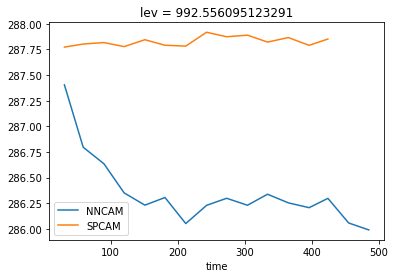

In [97]:
# Mean surface temperature drift
gw_avg(h0s.isel(lev=29), 'TAP').plot(label='NNCAM')
gw_avg(h0s_ref.isel(lev=29), 'TAP').plot(label='SPCAM')
plt.legend();

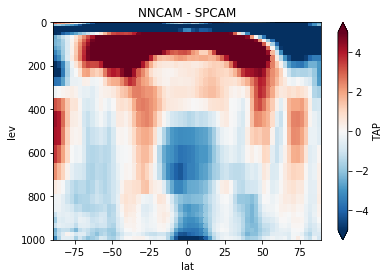

In [99]:
# Temperature difference for month 12
(h0s.TAP.isel(time=11).mean(dim='lon') - h0s_ref.TAP.isel(time=11).
 mean(dim='lon')).plot(yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r')
plt.title('NNCAM - SPCAM');

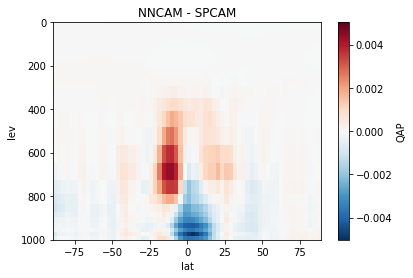

In [100]:
# Humidity difference for month 12
(h0s.QAP.isel(time=11).mean(dim='lon') - h0s_ref.QAP.isel(time=11).
 mean(dim='lon')).plot(yincrease=False, cmap='RdBu_r')
plt.title('NNCAM - SPCAM');

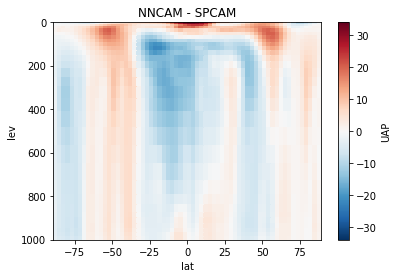

In [115]:
# U wind difference for month 12
(h0s.UAP.isel(time=11).mean(dim='lon') - h0s_ref.UAP.isel(time=11).
 mean(dim='lon')).plot(yincrease=False, cmap='RdBu_r')
plt.title('NNCAM - SPCAM');

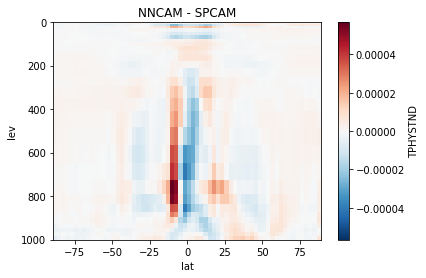

In [116]:
# Physics tendency teperature difference for month 12
(h0s.TPHYSTND.isel(time=11).mean(dim='lon') - h0s_ref.TPHYSTND.isel(time=11).
 mean(dim='lon')).plot(yincrease=False, cmap='RdBu_r')
plt.title('NNCAM - SPCAM');

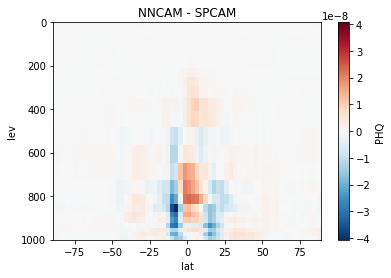

In [117]:
# Physics tendency humidity difference for month 12
(h0s.PHQ.isel(time=11).mean(dim='lon') - h0s_ref.PHQ.isel(time=11).
 mean(dim='lon')).plot(yincrease=False, cmap='RdBu_r')
plt.title('NNCAM - SPCAM');

So we can see that for this particular NNCAM version we have quite large deviations with a drift in NNCAM that seems to saturate at some point. 

The model seems to be stable, however. This is interesting since I remember a previous attempt using 32 columns crashed.

We can also look at the time-step level output which is saved in the `h1` files.

In [101]:
%%time
# Reading can take a while. Let's only read the files for one month.
h1s = xr.open_mfdataset('*h1.0000-11*', decode_times=False, concat_dim='time')

CPU times: user 108 ms, sys: 10.7 ms, total: 119 ms
Wall time: 1.57 s


We can now check whether the immediate outputs by the neural network are reasonable in the variables `TPHYSTND = NNDT` and `PHQ = NNDQ`.

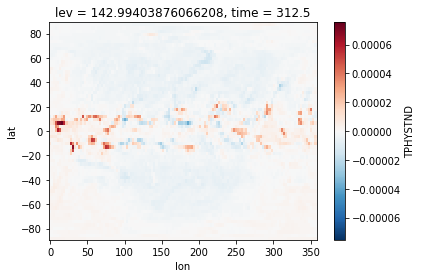

In [109]:
# Plot a horizontal slice at level 10
h1s.TPHYSTND.isel(time=10, lev=10).plot();

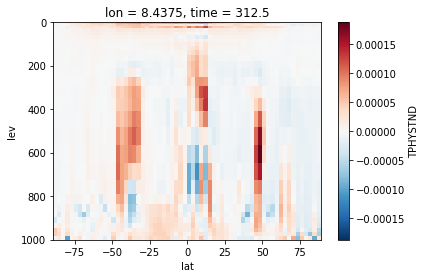

In [113]:
# Plot a vertical slice
h1s.TPHYSTND.isel(time=10, lon=3).plot(yincrease=False);

Nothing unreasonable on first sight. We have seen biases before however, for example when using 